In [1]:
import pandas as pd # algebraic computations , read and write to csv 

import numpy as np # linear algebra and arrays muniplication 

import requests, zipfile, io    # Needed to download and extract the data sets of dev and eval 

# from pandarallel import pandarallel       # Parallel computation on data frames
import time                               # measure excution time of some functions

############  importing the data visualization libraries :##############

import matplotlib.pyplot as plt
import seaborn as sns

############  Import Classifiers #################

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB

# Importing a model to split the training set from the evaluation set
from sklearn.model_selection import train_test_split 

############  Evaluation Metric  #################
from sklearn.metrics import f1_score , make_scorer

############  GridSearchCV #################
from sklearn.model_selection import GridSearchCV

################## Tuxtual data prprocessing ##################
from sklearn. feature_extraction.text import TfidfVectorizer 
import warnings
warnings.filterwarnings("ignore")
from os import path
from PIL import Image

import nltk
from wordcloud import WordCloud
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer ,word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
#### some libraries must be downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('pos_tag')
nltk.download('averaged_perceptron_tagger') 

%matplotlib inline
plt.style.use('seaborn-notebook' ) # plotting style

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading pos_tag: Package 'pos_tag' not found in
[nltk_data]     index
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### download and extract the data sets and make data frames for development and evaluation 

In [2]:
#############
def download_dataset(zip_file_url):
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    
download_dataset('https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip')



In [3]:
##### create data frames from the CSV files 

dev_df = pd.read_csv('./DSL2122_january_dataset/development.csv')    
eval_df = pd.read_csv('./DSL2122_january_dataset/evaluation.csv')

In [4]:
dev_df.head()

,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


In [5]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   ids        224994 non-null  int64 
 2   date       224994 non-null  object
 3   flag       224994 non-null  object
 4   user       224994 non-null  object
 5   text       224994 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.3+ MB


In [6]:
# check the lenght of data frames
print ("*" * 50 ,"\n" , f"the Development set containts {len(dev_df)} samples and {len(list(dev_df.columns)) - 1} features which are { list(dev_df.drop(['sentiment'],axis=1).columns) } " )
print ("*" * 50 , "\n" ,f"the Evaluation set containts {len(eval_df)} samples " )

************************************************** 
 the Development set containts 224994 samples and 5 features which are ['ids', 'date', 'flag', 'user', 'text'] 
************************************************** 
 the Evaluation set containts 74999 samples 


##### check the cardinality of each feature in the Training set 

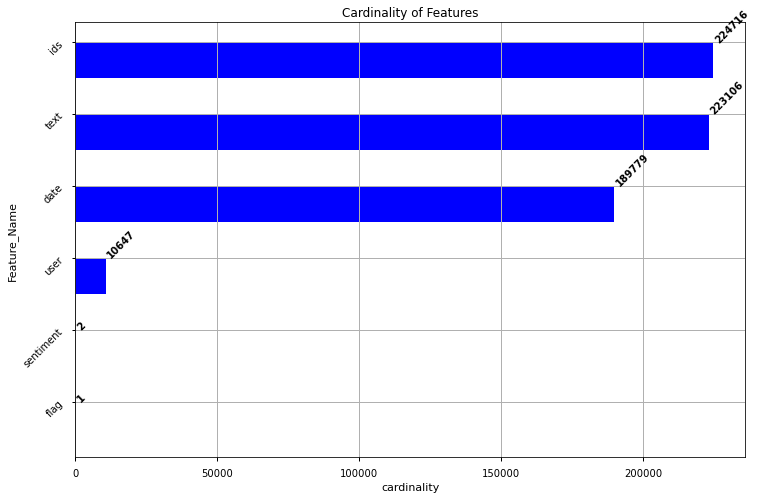

In [8]:
x = dev_df.nunique().sort_values().index
y = dev_df.nunique().sort_values().values

fig, ax = plt.subplots(figsize=(12,8))    
width = 0.5 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Cardinality of Features')
plt.grid()
plt.yticks(rotation=45)
plt.xlabel('cardinality')
plt.ylabel('Feature_Name') 
for i, v in enumerate(y):
    ax.text(v + 3, i + .25, str(v), color='black', fontweight='bold',rotation=45)
# plt.show()
plt.savefig("Cardinality of Features.png", dpi=300,  bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

#### 1- Ids feature :

In [9]:
# the percentage of unique ids in the data set is 
print(f" the percentage of unique ids in the data set is {100*dev_df.ids.nunique() / len(dev_df):.2f}%")

 the percentage of unique ids in the data set is 99.88%


In [10]:
# from the previous analysis we indicate that there are some duplicated reviews and we should investigate more 
# check for duplications in the data set we should make sure that the duplication is in all the features 
duplication_count = dev_df.drop(['sentiment'] , axis=1).duplicated().sum()
duplication_perc = 100* dev_df.drop(['sentiment'] , axis=1).duplicated().sum() /len (dev_df)
print("*" * 50 ,"\n" ,f"There are {duplication_count} duplicated samples , around {duplication_perc :0.3f}%  of the development set")
mask = dev_df.drop(['sentiment'] , axis=1).duplicated(keep=False)


************************************************** 
 There are 278 duplicated samples , around 0.124%  of the development set


In [11]:
# example of 2 reviews with the same text 
pd.set_option("max_colwidth", None)
df_dup = dev_df[mask]
df_dup.loc[df_dup.ids == 1978708145 , ["user" , "text"]]

,user,text
128,Tas_E,"@reneenay http://twitpic.com/6bjlw - Oooh, Weimaraner? They are soo pretty. My poor little dog has to have surgery next week."
103947,Tas_E,"@reneenay http://twitpic.com/6bjlw - Oooh, Weimaraner? They are soo pretty. My poor little dog has to have surgery next week."


In [12]:
# example of 2 reviews with the exact  same values of features 
pd.set_option("max_colwidth", None)
df_dup = dev_df[mask]
df_dup[df_dup.ids == 1978708145]

,sentiment,ids,date,flag,user,text
128,0,1978708145,Sun May 31 00:12:13 PDT 2009,NO_QUERY,Tas_E,"@reneenay http://twitpic.com/6bjlw - Oooh, Weimaraner? They are soo pretty. My poor little dog has to have surgery next week."
103947,1,1978708145,Sun May 31 00:12:13 PDT 2009,NO_QUERY,Tas_E,"@reneenay http://twitpic.com/6bjlw - Oooh, Weimaraner? They are soo pretty. My poor little dog has to have surgery next week."


#### 2- Flag feature :


In [13]:
print("*" * 50 ,"\n" ,f"The “Flag ” attribute has {dev_df.flag.nunique()} unique value (the same value ) in the development set so it's not useful for analysis")
print("*" * 50 ,"\n" ,f"The “Flag ” attribute has {eval_df.flag.nunique()} unique value (the same value ) in the evaluation set so it's not useful for analysis")


************************************************** 
 The “Flag ” attribute has 1 unique value (the same value ) in the development set so it's not useful for analysis
************************************************** 
 The “Flag ” attribute has 1 unique value (the same value ) in the evaluation set so it's not useful for analysis
